<a href="https://colab.research.google.com/github/riyanbagusb/KertasGuntingBatu/blob/main/KertasGuntingBatu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyek Akhir : Klasifikasi Gambar**

Nama: Bagus Budhi Riyanto

[Email](mailto:riyanbagusb@gmail.com) | [Dicoding](https://www.dicoding.com/users/riyanbagusb)

## **Dataset**

### **Download dataset**

Unduh [rockpaperscissors.zip](https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip) ke dalam folder "download".

In [1]:
!mkdir download

!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/download/rockpaperscissors.zip

--2021-07-14 16:18:31--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/download/rockpaperscissors.zip’

/content/download/r 100%[===================>] 307.92M  1.93MB/s    in 78s     

2021-07-14 16:19:49 (3.96 MB/s) - ‘/content/download/rockpaperscissors.zip’ saved [322873683/322873683]



### **Extract dataset**

Extract file yang telah diunduh ke dalam folder "dataset".

In [2]:
import zipfile
dataset = 'download/rockpaperscissors.zip'
extractor = zipfile.ZipFile(dataset, 'r')
extractor.extractall('dataset')
extractor.close()

### **Split dataset**

Install library "split-folders" dan bagi dataset menjadi:

**60% data training**

**40% data validasi**

In [3]:
!pip install split-folders
!pip install split-folders tqdm

In [4]:
import splitfolders

splitfolders.ratio('dataset/rockpaperscissors/rps-cv-images', output ='dataset/data_model', seed=None, ratio=(.6,.4))

Copying files: 2188 files [00:00, 3395.39 files/s]


### **Output dataset model**

periksa hasil split dataset apakah sudah sesuai.

In [5]:
dataset_dir = "dataset/rockpaperscissors/rps-cv-images/"
train_dir ="dataset/data_model/train/"
val_dir ="dataset/data_model/val/"

import os

model = ['paper', 'rock', 'scissors']

for i in model:
  print('\nJumlah gambar '+ i, len(os.listdir(dataset_dir + i)))
  print('Training   :', len(os.listdir(train_dir + i)))
  print('Validation :', len(os.listdir(val_dir + i)))


Jumlah gambar paper 712
Training   : 427
Validation : 285

Jumlah gambar rock 726
Training   : 435
Validation : 291

Jumlah gambar scissors 750
Training   : 450
Validation : 300


## **Pemodelan**

### **Augmentasi gambar**

teknik untuk menciptakan data-data baru dari data yang telah ada.

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

### **Image data generator**

mempersiapkan data training yang akan dipelajari oleh model.

struktur:
*   dir: direktori dataset
*   target_size: mengubah ukuran gambar (height, width)
*   batch_size: ukuran batch data.
*   class_mode: untuk klasifikasi lebih dari 2 kelas menggunakan 'categorical'



In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')
 
val_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


### **Model sequential**

Membangun arsitektur CNN (Convolutional Neural Network).

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### **Callback function**

Menghentikan training apabila akurasi sudah tercapai **(96%)**.

In [9]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      self.model.stop_training = True

optimalAccuracy = Callback()

### **Compile objek model**

menentukan **loss function** dan **optimizer**.

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

### **Training model**

Melakukan training model yang telah dibuat.

In [11]:
model.fit(
      train_generator,
      epochs=100,
      steps_per_epoch=35,
      validation_data=val_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[optimalAccuracy])

Epoch 1/100
35/35 - 9s - loss: 1.1212 - accuracy: 0.3500 - val_loss: 1.0813 - val_accuracy: 0.3500
Epoch 2/100
35/35 - 8s - loss: 1.0534 - accuracy: 0.4929 - val_loss: 1.0029 - val_accuracy: 0.4500
Epoch 3/100
35/35 - 8s - loss: 1.0623 - accuracy: 0.4214 - val_loss: 0.9756 - val_accuracy: 0.5500
Epoch 4/100
35/35 - 8s - loss: 0.9114 - accuracy: 0.6071 - val_loss: 0.9572 - val_accuracy: 0.6500
Epoch 5/100
35/35 - 8s - loss: 0.5513 - accuracy: 0.7786 - val_loss: 0.4733 - val_accuracy: 0.8500
Epoch 6/100
35/35 - 8s - loss: 0.4567 - accuracy: 0.8429 - val_loss: 0.6474 - val_accuracy: 0.6500
Epoch 7/100
35/35 - 8s - loss: 0.2873 - accuracy: 0.8786 - val_loss: 0.1639 - val_accuracy: 0.9500
Epoch 8/100
35/35 - 8s - loss: 0.3039 - accuracy: 0.8857 - val_loss: 0.4025 - val_accuracy: 0.8500
Epoch 9/100
35/35 - 8s - loss: 0.4408 - accuracy: 0.8429 - val_loss: 0.5821 - val_accuracy: 0.7000
Epoch 10/100
35/35 - 8s - loss: 0.3093 - accuracy: 0.9214 - val_loss: 0.5438 - val_accuracy: 0.7500
Epoch 11/

## **Testing**

### **Upload image**

Jika mendapat warning:

"Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable."

*   Go to chrome://settings/content/cookies
*   Turn off -> Block third-party cookies

In [40]:
from google.colab import files

uploaded = files.upload()

Saving 7cNxwgrraQGeA1LA.png to 7cNxwgrraQGeA1LA.png


### **Hasil testing**

7cNxwgrraQGeA1LA.png
Rock


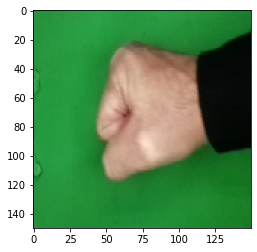

In [41]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def check_result(result):
  if result == 0:
    return 'Paper'
  elif result == 1:
    return 'Rock'
  elif result == 2:
    return 'Scissors'

def check_prediction():
  for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    result = model.predict(images, batch_size=10)

    print(fn)
    max_value = max(result[0])
    index_value = result[0].tolist().index(max_value)
    print(check_result(index_value))

check_prediction()